In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')

In [3]:
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [4]:
from pandas.tseries.offsets import MonthEnd

In [5]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')

In [6]:
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


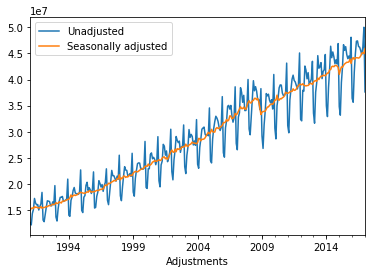

In [7]:
df.plot()

In [8]:
split_date = pd.Timestamp('01-01-2011')

In [9]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

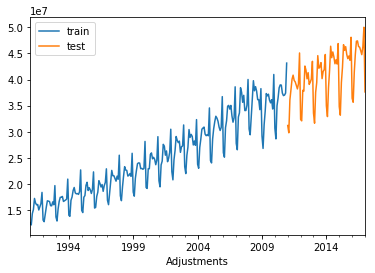

In [10]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [11]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [12]:
train_sc[:4]

array([[ 0.01402033],
       [ 0.        ],
       [ 0.0704258 ],
       [ 0.09531795]])

In [13]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [14]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [15]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [17]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
239/239 [==============================] - 1s - loss: 0.0178     
Epoch 2/200
239/239 [==============================] - 0s - loss: 0.0111     
Epoch 3/200
239/239 [==============================] - 0s - loss: 0.0107     
Epoch 4/200
239/239 [==============================] - 0s - loss: 0.0104     
Epoch 5/200
239/239 [==============================] - 0s - loss: 0.0100     
Epoch 6/200
239/239 [==============================] - 0s - loss: 0.0103       
Epoch 7/200
239/239 [==============================] - 0s - loss: 0.0102     
Epoch 00006: early stopping


In [18]:
y_pred = model.predict(X_test)

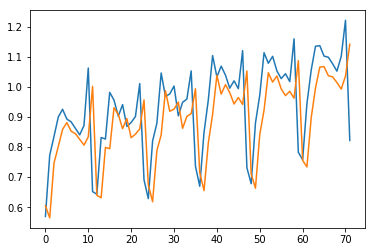

In [19]:
plt.plot(y_test)
plt.plot(y_pred)

In [20]:
from keras.layers import LSTM

In [21]:
X_train.shape

(239, 1)

In [22]:
X_train[:, None].shape

(239, 1, 1)

In [23]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [24]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 1s - loss: 0.0810     
Epoch 2/100
239/239 [==============================] - 0s - loss: 0.0264     
Epoch 3/100
239/239 [==============================] - 0s - loss: 0.0212     
Epoch 4/100
239/239 [==============================] - 0s - loss: 0.0169     
Epoch 5/100
239/239 [==============================] - 0s - loss: 0.0140     
Epoch 6/100
239/239 [==============================] - 0s - loss: 0.0121     
Epoch 7/100
239/239 [==============================] - 0s - loss: 0.0109     
Epoch 8/100
239/239 [==============================] - 0s - loss: 0.0107     
Epoch 9/100
239/239 [==============================] - 0s - loss: 0.0104     
Epoch 10/100
239/239 [==============================] - 0s - loss: 0.0104     
Epoch 11/100
239/239 [==============================] - 0s - loss: 0.0103     
Epoch 12/100
239/239 [==============================] - 0s - loss: 0.0103     
Epoch 13/100
239/239 [==============================] - 0s - 

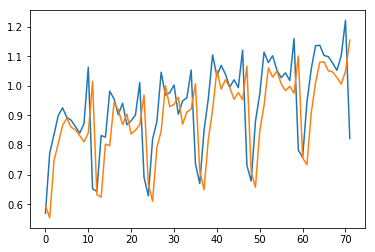

In [26]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [27]:
train_sc.shape

(240, 1)

In [28]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [29]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [30]:
train_sc_df.head()

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.01402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.00000,0.01402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [33]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [34]:
X_train.shape

(228, 12)

In [35]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [36]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s - loss: 0.0137     
Epoch 2/200
228/228 [==============================] - 0s - loss: 0.0078     
Epoch 3/200
228/228 [==============================] - 0s - loss: 0.0067     
Epoch 4/200
228/228 [==============================] - 0s - loss: 0.0058     
Epoch 5/200
228/228 [==============================] - 0s - loss: 0.0051     
Epoch 6/200
228/228 [==============================] - 0s - loss: 0.0045     
Epoch 7/200
228/228 [==============================] - 0s - loss: 0.0043     
Epoch 8/200
228/228 [==============================] - 0s - loss: 0.0032     
Epoch 9/200
228/228 [==============================] - 0s - loss: 0.0029     
Epoch 10/200
228/228 [==============================] - 0s - loss: 0.0024     
Epoch 11/200
228/228 [==============================] - 0s - loss: 0.0021     
Epoch 12/200
228/228 [==============================] - 0s - loss: 0.0018     
Epoch 13/200
228/228 [==============================] - 0s - 

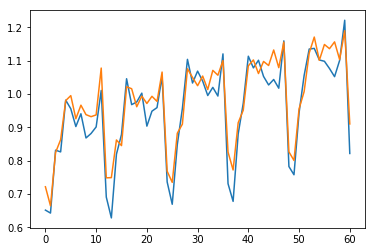

In [38]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

In [39]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [40]:
X_train_t.shape

(228, 1, 12)

In [41]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 0s - loss: 0.0594     
Epoch 2/100
228/228 [==============================] - 0s - loss: 0.0079     
Epoch 3/100
228/228 [==============================] - 0s - loss: 0.0062     
Epoch 4/100
228/228 [==============================] - 0s - loss: 0.0053     
Epoch 5/100
228/228 [==============================] - 0s - loss: 0.0049     
Epoch 6/100
228/228 [==============================] - 0s - loss: 0.0042     
Epoch 7/100
228/228 [==============================] - 0s - loss: 0.0037     
Epoch 8/100
228/228 [==============================] - 0s - loss: 0.0035     
Epoch 9/100
228/228 [==============================] - 0s - loss: 0.0031     
Epoch 10/100
228/228 [==============================] - 0s - loss: 0.0028     
Epoch 11/100
228/228 [==============================] - 0s - loss: 0.0028     
Epoch 12/100
228/228 [==============================] - 0s - loss: 0.0030     
Epoch 00011: early stopping


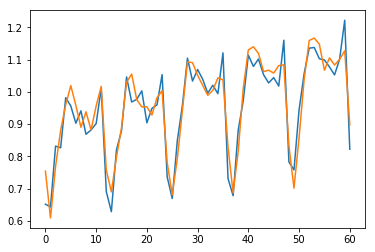

In [45]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [ ]:
#EX

In [48]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [49]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 2s - loss: 0.0454     
Epoch 2/100
228/228 [==============================] - 2s - loss: 0.0098     
Epoch 3/100
228/228 [==============================] - 2s - loss: 0.0074     
Epoch 4/100
228/228 [==============================] - 2s - loss: 0.0069     
Epoch 5/100
228/228 [==============================] - ETA: 0s - loss: 0.006 - 2s - loss: 0.0067     
Epoch 6/100
228/228 [==============================] - 2s - loss: 0.0070     
Epoch 7/100
228/228 [==============================] - 2s - loss: 0.0066     
Epoch 8/100
228/228 [==============================] - 2s - loss: 0.0067     
Epoch 9/100
228/228 [==============================] - 2s - loss: 0.0063     
Epoch 10/100
228/228 [==============================] - 2s - loss: 0.0060     
Epoch 11/100
228/228 [==============================] - 2s - loss: 0.0059     
Epoch 12/100
228/228 [==============================] - 2s - loss: 0.0056     
Epoch 13/100
228/228 [===============

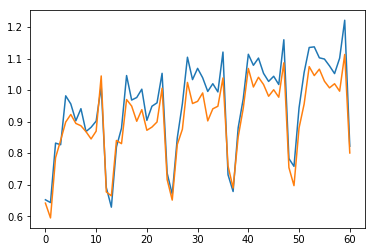

In [52]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [67]:
from keras.datasets import mnist

In [68]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [69]:
X_train.shape

(60000, 28, 28)

In [81]:
X_train_t = X_train.reshape(X_train.shape[0], -1, 1)
X_test_t = X_test.reshape(X_test.shape[0], -1, 1)

In [82]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [83]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [87]:
K.clear_session()

model = Sequential()

model.add(LSTM(32, input_shape=X_train.shape[1:], return_sequences= True))

model.add(Dense(10), activation = 'softmax')

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

ValueError: Input 0 is incompatible with layer lstm_1: expected ndim=3, found ndim=2

In [88]:
model.fit(X_train, y_train_cat,
          batch_size=32,
          epochs=100,
          validation_split=0.3,
          shuffle=True,
          verbose=2,
          )

RuntimeError: The model needs to be compiled before being used.

In [ ]:
model.evaluate(X_test, y_test_cat)